# Initial PCA notebook v2

The goal of this notebook is to look at how to plot an initial PCA of a fingerprints generated from the dataset.  
It'll look at how to get a set of fingerprints for the molecules, doing a PCA on these fingerprints, and plotting the result as a scattergraph.  It should be a useful template for doing more complex analysis in the future.

v2 - Rather than just making fingerprints for unique smiles, I wanted to include the fingerprints with the entire df, so that we cau utilise the other information in the dataset (ie the activity information).  To do this, I've added fingerprints directly to the dataframes.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import pandas as pd
from rdkit.Chem import PandasTools
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

RDKit WARNING: [10:10:17] Enabling RDKit 2019.09.3 jupyter extensions


## 1. Load the data

In [2]:
df = pd.read_excel("mchem_data.xlsx")

# Filter the data by reaction and enzyme type
#df = df[df['reaction'].isin(['Carboxylic acid reduction'])]
df = df[df['enzyme_type'].isin(['AlOx'])]
df.reset_index(inplace=True, drop=True)

df.head(n=2)

,reaction,enzyme_type,enzyme_name,short_citation,html_doi,cascade_num,substrate_1_smiles,substrate_2_smiles,product_1_smiles,temperature,...,specific_activity,conversion,conversion_time,categorical,binary,added_by,selectivity,auto_generated,paper,_id
0,Primary alcohol oxidation,AlOx,AcCO_6,"Ramsden et al, 2019, JACS",https://doi.org/10.1021/jacs.8b11561,1,CCCCCCO,NaN,CCCCCC=O,30,...,NaN,NaN,24.0,NaN,True,5ecbe762bea4f4b3bb8a13bc,NaN,False,5f0ded2ab9d32b06f17b7d65,5f0ded2ab9d32b06f17b7d67
1,Primary alcohol oxidation,AlOx,AcCO_6,"Ramsden et al, 2019, JACS",https://doi.org/10.1021/jacs.8b11561,2,CCCCCCCO,NaN,CCCCCCC=O,30,...,NaN,NaN,24.0,NaN,True,5ecbe762bea4f4b3bb8a13bc,NaN,False,5f0ded2ab9d32b06f17b7d65,5f0ded2ab9d32b06f17b7d68


## 2. Fingerprint generators

Many different fingerprints are available.   

This is a useful resource: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiSme2EtM3tAhVsVBUIHUSCBBYQFjABegQIBBAC&url=https%3A%2F%2Fwww.rdkit.org%2FUGM%2F2012%2FLandrum_RDKit_UGM.Fingerprints.Final.pptx.pdf&usg=AOvVaw1on_e9_FUhFQ2d_SsG1Su-

Also, the rdkit page: https://rdkit.org/docs/source/rdkit.Chem.rdFingerprintGenerator.html

The default 'rdkitfingerprint' is a good one to try first, followed by morgan fingerprints.  
Also look at different fingerprint lengths (try 1024), and the morgan fingerprint radius.


In [3]:
"""
Fingerprint generators
"""

# default rdkit fingerprints, probably try this first
rd_arguments = {'fpSize': 2048}
fp_gen_rd = rdFingerprintGenerator.GetRDKitFPGenerator(**rd_arguments)

# morgan fingerprints (also called extended connectivity fingeprints (ECFP)), also try these.
mg_arguments = {'includeChirality': True,
                'radius': 2,
                'fpSize': 2048}
fp_gen_mg = rdFingerprintGenerator.GetMorganGenerator(**mg_arguments)

# atom pair - I've not looked into these much, could be worth intestigating?
ap_arguments = {'includeChirality': True,
                'fpSize': 2048}
ap_fp_gen = rdFingerprintGenerator.GetAtomPairGenerator(**ap_arguments)

# toplogical torsion fingerprints.  I've not looked at these either yet.. also could be interesting?
tt_arguments = {'includeChirality': True,
                'fpSize': 2048}
tt_fp_gen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(**tt_arguments)


# TEST
test_smi = 'CCC(O)CCCC=O'
test_mol = Chem.MolFromSmiles(test_smi)
fp = fp_gen_rd.GetFingerprint(test_mol)
#print(fp)
print(len(list(fp)))
#print(list(fp))

2048


## 3. Fingerprints to dataframe

,reaction,enzyme_type,enzyme_name,short_citation,html_doi,cascade_num,substrate_1_smiles,substrate_2_smiles,product_1_smiles,temperature,...,conversion_time,categorical,binary,added_by,selectivity,auto_generated,paper,_id,substrate_1_mols,substrate_1_fps
0,Primary alcohol oxidation,AlOx,AcCO_6,"Ramsden et al, 2019, JACS",https://doi.org/10.1021/jacs.8b11561,1,CCCCCCO,NaN,CCCCCC=O,30,...,24.0,NaN,True,5ecbe762bea4f4b3bb8a13bc,NaN,False,5f0ded2ab9d32b06f17b7d65,5f0ded2ab9d32b06f17b7d67,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Primary alcohol oxidation,AlOx,AcCO_6,"Ramsden et al, 2019, JACS",https://doi.org/10.1021/jacs.8b11561,2,CCCCCCCO,NaN,CCCCCCC=O,30,...,24.0,NaN,True,5ecbe762bea4f4b3bb8a13bc,NaN,False,5f0ded2ab9d32b06f17b7d65,5f0ded2ab9d32b06f17b7d68,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

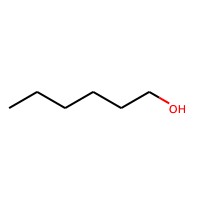
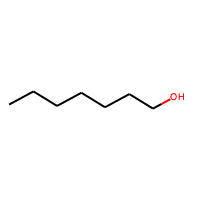

In [4]:
# Making two separate dfs, in which any rows with nan values for substrates or products are removed
# I've made a copy beforehand because pandas was giving a warning otherwise.
sub_df = df.copy()
sub_df.dropna(subset=['substrate_1_smiles'], inplace=True)

prod_df = df.copy()
prod_df.dropna(subset=['product_1_smiles'], inplace=True)

# add mol columns (http://rdkit.org/docs/source/rdkit.Chem.PandasTools.html)
PandasTools.AddMoleculeColumnToFrame(sub_df,'substrate_1_smiles', 'substrate_1_mols')
PandasTools.AddMoleculeColumnToFrame(prod_df,'product_1_smiles', 'product_1_mols')

# add fingerprints
generator = fp_gen_rd
sub_df['substrate_1_fps'] = sub_df['substrate_1_mols'].apply(generator.GetFingerprint)
prod_df['product_1_fps'] = prod_df['product_1_mols'].apply(generator.GetFingerprint)
sub_df.head(n=2)

## 4. Do a PCA on the fingerprints

Use sklearn to do the pca.  
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Then add the resulting 2D co-ordinates to a new dataframe, and plot using seaborn.  

This was a very useful resource: http://practicalcheminformatics.blogspot.com/2019/11/visualizing-chemical-space.html


In [5]:
# plotting options
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

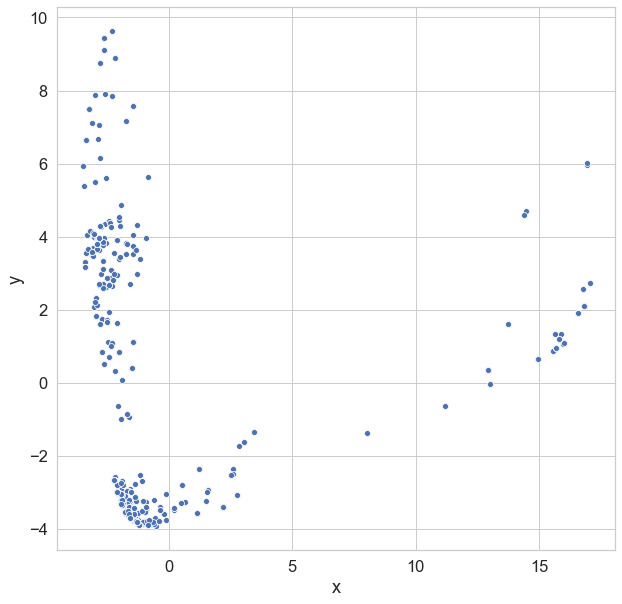

In [6]:
"""
1. Substrates
""" 

# This code is pretty inefficient, but gets the job done.
# It could be optimised quite a bit to run faster / be cleaner.

# Do PCA to get 2D co-ordinates
pca = PCA(n_components=2)
crds = pca.fit_transform(list(sub_df['substrate_1_fps']))

# Add co-ordinates to a new dataframe
pca_df = pd.DataFrame(crds,columns=["x","y"])

# Combine co-ordinates with original substrate dataframe
sub_df['x'] = pca_df['x']
sub_df['y'] = pca_df['y']

ax = sns.scatterplot(data=sub_df,x="x",y="y")

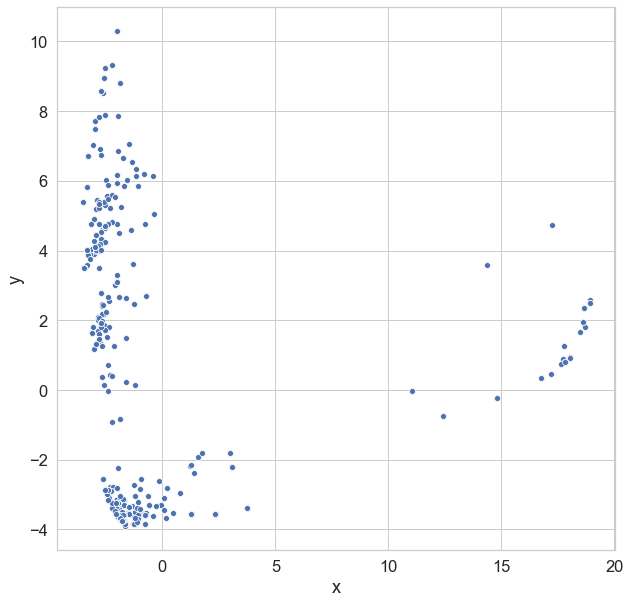

In [7]:
"""
2. Products
""" 

pca = PCA(n_components=2)
crds = pca.fit_transform(list(prod_df['product_1_fps']))
pca_df = pd.DataFrame(crds,columns=["x","y"])
prod_df['x'] = pca_df['x']
prod_df['y'] = pca_df['y']

ax = sns.scatterplot(data=prod_df,x="x",y="y")

Because there are multiple datapoints for each substrate / product (multiple enzymes), there are lots of points here which over-lap.  

Thinking about how to present multiple data points will be important.  For example, showing active vs non-active, which data point should we show?  I think maybe showing activing if ANY row is active might be one option.

# What next?


**First try..**
- Colour points based on which cluster the enzyme in that row is in.  (Ie for CARs - is the data from bacterial CAR or Fungal CAR?)

- Look at the same analysis as a t-sne.

- Plot active vs non-active.  Make a plot of just specific activity / conversion, colour points like a heat map for activity.

- Can we find out what the molecules are which appear to be quite different to the others? (find molecules with PC_1 > 10?  Then draw these in RDKit).  We'd need to also add the smiles lists into the PCA dataframe beforehand.  (are these maybe sugars?) - should these be analysed separetly?

- Look at different fingerprints, how much of an impact does this have?

- Create a function that can run this entire workflow.  Use this function to explore the effects of various options.

**Then, more advanded..**
- Do unsupervised learning (k-nn), to cluster related molecules.  Colour clusters on PCA.  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Get databases of relevent molecules, extract potential substrates (by doing a SMARTS query), include these in the PCA and overlay the activity data with the PCA data.
 * https://pubs.acs.org/doi/10.1021/acs.jcim.8b00285
 * http://chemyang.ccnu.edu.cn/ccb/database/PADFrag/index.php/help/download
 * http://files.docking.org/bb/
 * https://downloads.emolecules.com/free/
 * all of chembl?  ambitious https://www.ebi.ac.uk/chembl/

- Check out the notebooks in this repo https://github.com/PatWalters/workshop/blob/master/predictive_models/
